# Testing the prompts for the RAG implementation

Purpose of the notebook: test which queries and prompts work best; optionally which embedding models / LLM models, PDF text extraction approaches perform best
Evaluate on a manually coded validation set based on three sample reports

Evaluate
1.  RAG retrieval
2.  RAG generation

## Preparation

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import urllib3
import pymupdf
import requests
import os
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# import OpenAI API key from environment variable
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
#os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Select sample reports
Source: Sustainability Reporting Navigator (crowd-source list of CSRD-compliant reports for fiscal years starting on 01/01/2024)

Download CSV with information on all reports on the 08/04/2025 https://www.sustainabilityreportingnavigator.com/#/csrdreports 

In [29]:
# Open the csv data file
reports_24 = pd.read_csv('esg_reports_2024.csv')
print(len(reports_24))

277


In [30]:
# randomly select 3 reports from 2024
sample = reports_24.sample(n=3, random_state=3)
sample.head()

,Unnamed: 0,company_withAccessInfo,link,country,sector,industry,publication date,pages PDF,auditor
220,19,Continental AG,https://annualreport.continental.com/2024/en/s...,Germany,Transportation,Auto Parts,2025-03-18,125,PwC
58,266,Schneider Electric*,https://www.se.com/ww/en/assets/564/document/5...,France,Resource Transformation,Electrical & Electronic Equipment,2025-03-26,186,PwC & Mazars
89,103,Philips,https://www.results.philips.com/publications/a...,Netherlands,Infrastructure,Electric Utilities & Power Generators,2025-02-21,85,EY


## 2. Manually hand code ground truth = validation set

In [22]:
validation_set = pd.read_excel('validation_dataset.xlsx')
print(validation_set.head())

          report_name query  \
0  ContinentalAG_2024  S1_F   
1  ContinentalAG_2024  S1_F   
2  ContinentalAG_2024  S1_F   
3  ContinentalAG_2024  S1_F   
4  ContinentalAG_2024  S1_F   

                                                text page_number  
0  Occupational safety and health\nContinental ha...    181, 182  
1  Occupational safety and health\nContinental op...         174  
2  This section describes the management approach...         176  
3  Occupational safety and health\nAs part of the...         189  
4  Substances of concern and very high concern\nC...         153  


In [ ]:
# print how many text chunks per query, per report name
print(validation_set.groupby(['report_name', 'query']).size())

report_name         query
ContinentalAG_2024  S1_A     14
                    S1_B     12
                    S1_C     26
                    S1_D     19
                    S1_E     19
                    S1_F     11
                    S1_G     12
                    S1_H     23
                    S1_I      4
                    S1_J     12
                    S1_K     12
                    S1_L      5
dtype: int64


Text(0.5, 1.0, 'Distribution of Text Chunk Lengths')

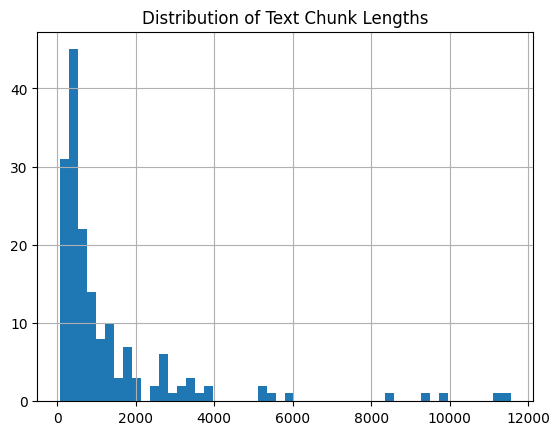

In [21]:
# graph the number of characters per text chunk
validation_set['text_length'] = validation_set['text'].apply(lambda x: len(x))
validation_set['text_length'].hist(bins=50)
plt.title('Distribution of Text Chunk Lengths')

## 3. Evaluate the performance of different approaches


In [42]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def evaluate_retrieval_on_sentence_level(retrieved_docs, ground_truth_texts):
    """
    Evaluates retrieval performance on a sentence level.

    Args:
        retrieved_docs (list): A list of Document objects retrieved by LangChain.
        ground_truth_texts (list): A list of ground-truth text snippets from the validation set.

    Returns:
        dict: A dictionary containing precision, recall, and f1-score.
    """
    # 1. Extract all ground-truth sentences into a set for efficient lookup.
    # The NLTK 'punkt' tokenizer is used, which is effective for English.
    all_ground_truth_sentences = set()
    for text in ground_truth_texts:
        sentences = sent_tokenize(text)
        # Optional: clean sentences to remove leading/trailing whitespace
        all_ground_truth_sentences.update([s.strip() for s in sentences if s.strip()])

    if not all_ground_truth_sentences:
        # If there are no ground truth sentences, we can't measure performance.
        # Returning 1.0 assumes perfect performance for queries with no expected answer.
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0} 

    # 2. Extract all retrieved sentences and identify which ones match the ground truth.
    all_retrieved_sentences = set()
    found_ground_truth_sentences = set()

    for doc in retrieved_docs:
        chunk_sentences = sent_tokenize(doc.page_content)
        for sentence in chunk_sentences:
            cleaned_sentence = sentence.strip()
            if cleaned_sentence:
                all_retrieved_sentences.add(cleaned_sentence)
                if cleaned_sentence in all_ground_truth_sentences:
                    found_ground_truth_sentences.add(cleaned_sentence)

    # 3. Calculate metrics based on the sentence counts.
    true_positives = len(found_ground_truth_sentences)
    false_positives = len(all_retrieved_sentences) - true_positives
    false_negatives = len(all_ground_truth_sentences) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"precision": precision, "recall": recall, "f1": f1}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [43]:
# --- Example of how to apply this in your main loop ---
evaluation_results = []

for report_name, queries_results in all_results.items():
    for query_key, retrieved_documents in queries_results.items():
        
        # Get the corresponding ground-truth texts from the validation set
        gt_texts = validation_set[
            (validation_set['report_name'] == report_name) & 
            (validation_set['query'] == query_key)
        ]['text'].tolist()

        if not gt_texts:
            continue

        # Perform the evaluation
        scores = evaluate_retrieval_on_sentence_level(retrieved_documents, gt_texts)
        
        evaluation_results.append({
            "report_name": report_name,
            "query": query_key,
            **scores
        })

# Display results in a clear DataFrame
df_evaluation = pd.DataFrame(evaluation_results)
print(df_evaluation)

           report_name query  precision    recall        f1
0   ContinentalAG_2024  S1_A   0.020000  0.016393  0.018018
1   ContinentalAG_2024  S1_B   0.040816  0.005587  0.009828
2   ContinentalAG_2024  S1_C   0.000000  0.000000  0.000000
3   ContinentalAG_2024  S1_D   0.000000  0.000000  0.000000
4   ContinentalAG_2024  S1_E   0.018182  0.015625  0.016807
5   ContinentalAG_2024  S1_F   0.016129  0.018868  0.017391
6   ContinentalAG_2024  S1_G   0.123077  0.078431  0.095808
7   ContinentalAG_2024  S1_H   0.120000  0.064286  0.083721
8   ContinentalAG_2024  S1_I   0.000000  0.000000  0.000000
9   ContinentalAG_2024  S1_J   0.134146  0.100917  0.115183
10  ContinentalAG_2024  S1_K   0.133333  0.048485  0.071111
11  ContinentalAG_2024  S1_L   0.000000  0.000000  0.000000


### 0: Baseline approach based on Ni et al. (2023)
based on: Ni, J., Bingler, J., Colesanti-Senni, C., Kraus, M., Gostlow, G., Schimanski, T., Stammbach, D., Vaghefi, S. A., Wang, Q., Webersinke, N., Wekhof, T., Yu, T., & Leippold, M. (2023). CHATREPORT: Democratizing Sustainability Disclosure Analysis through LLM-based Tools. Swiss Finance Institute Research Paper, No. 23-111. https://doi.org/10.48550/arXiv.2307.15770

- PDF text extraction: MyPuPDF
- Embedding model: OpenAI text-embedding-ada-002

In [26]:
# Code based on Ni et al. (2023)
TOP_K = 20
CHUNK_SIZE = 500
CHUNK_OVERLAP = 20

# 1. Load the PDF
def load_pdf(path=None, url=None):
    assert (path is not None) != (url is not None), "Either path or url must be provided"
    
    if path:
        return pymupdf.open(path)
    else:
        response = requests.get(url)
        pdf_bytes = io.BytesIO(response.content)
        return pymupdf.open(stream=pdf_bytes, filetype='pdf')
    
# 2. Extract text from the PDF
def extract_text(pdf):
    text_list = [page.get_text() for page in pdf]
    all_text = ''.join(text_list)
    return text_list, all_text

# 4. Create or Load Vector Store
def get_retriever(pdf, db_path, top_k=TOP_K):
    embeddings = OpenAIEmbeddings()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    if os.path.exists(db_path):
        doc_search = FAISS.load_local(db_path, embeddings=embeddings, allow_dangerous_deserialization=True)
    else:
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

# 5. Retrieve relevant chunks
def retrieve_chunks(retriever, queries):
    section_text_dict = {}

    for key, prompts in queries.items():
        if key == 'general' and isinstance(prompts, list):
            combined_docs = []
            for prompt in prompts:
                combined_docs.extend(retriever.invoke(prompt)[:5])
            section_text_dict[key] = combined_docs
        else:
            section_text_dict[key] = retriever.invoke(prompts)
    
    return section_text_dict

In [27]:
# Defined retrieval queries based on the ESRS S1 requirements

QUERIES = {
    #'general': ["What is the company of the report?", "What sector does the company belong to?", "Where is the company located?"],
    'S1_A': "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    'S1_B': "What are the material impacts on the company’s own workforce, who is affected, and how are these impacts managed?",
    'S1_C': "How does the company identify, prevent, and address negative impacts on its own workforce and how is affected by them?",
    'S1_D': "What are the company’s material positive impacts on its own workforce, and who benefits from them?",
    'S1_E': "What are the company’s human rights and labor rights commitments for its own workforce, what violations have occured, how were they managed? Which operations are considered at significant risk for human rights violations such as forced labor, child labor, or trafficking?",
    'S1_F': "How does the company manage workplace accident prevention?",
    'S1_G': "What policies does the company have in place to eliminate discrimination and promote diversity and inclusion within its own workforce, and how are these policies implemented and enforced?",
    'S1_H': "When and how does the company engage with its own workforce or their representatives in decision-making processes and who in the organization is responsible that engagement influences strategy and operations? How does the company assess the effectiveness of its workforce engagement practices?",
    'S1_I': "Has the company taken any actions to provide or enable remedy for negative impacts on its own workforce, and how does it ensure that such remedies are appropriate and effective?",
    'S1_J': "What channels are available for people in the company’s own workforce to raise concerns or needs, how are these channels supported, protected, and monitored?",
    'S1_K': "How does the company ensure that its employees receive adequate wages?",
    'S1_L': "To what extent does the company’s own workforce receive social protection, and how does the company address employees who are not yet covered by such protections?",
}

In [31]:
# Now apply the functions to the 3 sampled reports
all_results = {}

def prepare_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "", name)

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_OpenAI/{filename}"
        retriever, doc_search = get_retriever(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")



Processing: ContinentalAG_2024

Processing: SchneiderElectric_2024

Processing: Philips_2024


Note: Ressorces needed for 3 reports
- Time: 1.5 min (--> 13 h for 500 reports)
- Costs: 0.2 Dollar (--> 100$ for 500 reports)

In [47]:
# save results
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.to_csv('retrieval_results_0_OpenAI.csv', index=True)

In [23]:
# read in the results
retrieval_results = pd.read_csv('retrieval_results_0_OpenAI.csv', index_col=0)
print(retrieval_results.head())

                                                                     S1_A  \
ContinentalAG_2024      [Document(id='f70624ef-9430-4e33-9d99-a9b819d9...   
SchneiderElectric_2024  [Document(id='936599b4-792a-4a1e-9989-bffdbf10...   
Philips_2024            [Document(id='bd852d12-c665-44a9-8e08-d4d8b338...   

                                                                     S1_B  \
ContinentalAG_2024      [Document(id='fdbd762e-227e-4497-8db1-93efb79a...   
SchneiderElectric_2024  [Document(id='f47c1f60-1031-4d04-b28f-4344d0e4...   
Philips_2024            [Document(id='bd852d12-c665-44a9-8e08-d4d8b338...   

                                                                     S1_C  \
ContinentalAG_2024      [Document(id='fdbd762e-227e-4497-8db1-93efb79a...   
SchneiderElectric_2024  [Document(id='f8c3f3d8-aa22-4292-8773-0877a8e3...   
Philips_2024            [Document(id='a2a532a9-1887-4d22-ae91-6eea603e...   

                                                                     S1_D

### Evaluate PDF Text Extraction
- OCR (Optical Character Recognition) with MyPuPDF: This method involves utilizing open source 3rd party technology (Tesseract) to scan the page for images and to convert that imagery into text. Imagine PDFs which contain screenshots of information, these will just be identified as “image” within the PDF, but somehow we want machine-readable text. This method uses PyMuPDF’s Page.get_textpage_ocr()function to take on the heavy lifting. https://medium.com/@pymupdf/text-extraction-strategies-with-pymupdf-dd0ef2461847 
    - Limitations: Slower processing times, Accuracy depends on image quality, Higher computational and memory requirements, May introduce errors in recognition
- Docling OCR